# Creating Models to Predict Customer Churn
## The process to create a predictive model is as follows...
### - Aquire the Data
- Access the database from SQL and store into a pandas dataframe
- Split the data into train, test, and validate

### - Prep the Data (stored in prepare.py or done in notebook)
- Deal with missing values identified in preparation.ipynb
- Create columns for new features, such as dummy variables or derived variables

### -  Split the Data
#### Train
- 70 percent of the data
- Create models using different types (logistic regression, decision tree, etc.)
- Adjust parameters of each model
- Identify top 3 models used on train data

#### Validate
- 20 percent of the data
- Determine if the models created on train overfit to the data
- Determine the top 1 model

#### Test
- 10 percent of the data
- Test only on the best model
- Simulates real world, unseen data

### - Explore the Data
- Exploration on the train data set only, the rest of the data remains unseen
- Identify Predictor Variables (X) and Target Variable (y)
- Univariate Analysis (one variable)
    - For continuous variables, what is the central tendency/range and are there any outliers/missing values?
    - For discrete variables, how are they distributed?
- Bivariate Analysis (more than one variable)
    - Using hypothesis testing, are there any variables with a strong relationship?
    
### - Create Models
- Baseline is the best guess, we want our model to perform better than this
- Using classification models, determine the best mix of data features and model parameters for train
- Validate the top 3 models
- Test the best model

### - Form Conclusions

### - Create the CSV File

# Imports

In [1]:
# python files that contain the functions to aquire and prep the data
import acquire
import prepare

# import python libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ignoring warnings
import warnings
warnings.filterwarnings("ignore")

# importing hypothesis tests
from scipy.stats import chi2_contingency
from scipy.stats import ttest_1samp
from scipy.stats import ttest_ind

# importing functions to create the various models
# this project will use classification machine learning:
# Logistic Regression, Decision Tree, Random Forest, and K-Nearest Neighbor
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

# importing functions to access model metrics, such as accuracy and the confusion matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

print('Imports complete.')

Imports complete.


# Acquire

In [2]:
# aquiring data and using head to check everything is good
df = acquire.get_churn_data()
df.head()

,customer_id,gender,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,internet_service_type_id,online_security,...,streaming_movies,contract_type_id,paperless_billing,payment_type_id,monthly_charges,total_charges,churn,contract_type,payment_type,internet_service_type
0,0003-MKNFE,Male,0,No,No,9,Yes,Yes,1,No,...,Yes,1,No,2,59.9,542.4,No,Month-to-month,Mailed check,DSL
1,0013-MHZWF,Female,0,No,Yes,9,Yes,No,1,No,...,Yes,1,Yes,4,69.4,571.45,No,Month-to-month,Credit card (automatic),DSL
2,0015-UOCOJ,Female,1,No,No,7,Yes,No,1,Yes,...,No,1,Yes,1,48.2,340.35,No,Month-to-month,Electronic check,DSL
3,0023-HGHWL,Male,1,No,No,1,No,No phone service,1,No,...,No,1,Yes,1,25.1,25.1,Yes,Month-to-month,Electronic check,DSL
4,0032-PGELS,Female,0,Yes,Yes,1,No,No phone service,1,Yes,...,No,1,No,3,30.5,30.5,Yes,Month-to-month,Bank transfer (automatic),DSL


# Prep

In [3]:
# prep the data with the Prepare file
df = prepare.prep_telco_df(df)

No duplicates found.
Dummy variables for gender created as "male".
Yes/No column values changed to boolean, 0 as no and 1 as yes
Combined variable for phone_service + multiple lines created.
Combined variable for partner + dependents created.
Simplified features: security, backup, protection, support, contract, internet type, and payment type.
Column for service type added.
Added feature for tenure in years.
Converted total_charges to float for easier manipulation.
Data prep complete.




In [4]:
train, test, validate = prepare.train_test_validate(df)

train shape:  (5070, 23) , validate shape:  (1268, 23) , test shape:  (705, 23)

train percent:  72.0 , validate percent:  18.0 , test percent:  10.0


# Explore
- determine if more prep is needed
    - do we need other dummy variables or features
- determine X and y variables
- what factores drive churn?

In [5]:
# a look at each feature
# Churn is the target (y) variable, it is what we are trying to predict
train.head(3).T

,855,2823,5656
customer_id,6923-EFPNL,2004-OCQXK,2542-HYGIQ
senior_citizen,0,0,0
tenure_months,4,1,1
phone_service,2,1,1
online_security,0,0,0
online_backup,0,0,0
device_protection,0,0,0
tech_support,0,0,0
streaming_tv,0,0,0
streaming_movies,0,1,0


### Categorical vs. Continuous Features
- Categorical
    - senior citizen
    - gender
    - phone service
    - internet service
    - security
    - backup
    - device protection
    - tech support
    - streaming
    - contract
    - partner+dependents
    - CHURN (our target variable)
- Continuous
    - total charges
    - monthly charges
    - tenure in months
    - tenure in years

## For a quick overall look at features and how they correlate to each other, we start with a sns correlation heatmap

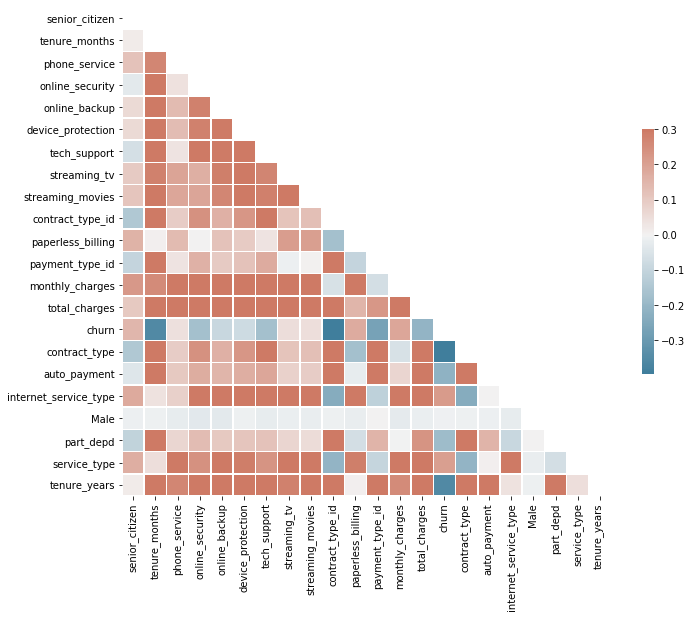

In [6]:
# Correlation heat map
# creating the correlation of each feature against each other
corr = train.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

### Takeaways
- highest correlation are the darker blue or red colors
- the darkest colors associated with churn are 
    - contract type
    - tenure
    - charges
    - payment type
    - tech support

## Tech Support
- Does tech support reduce churn?
- The correlation map above suggested a slight correlation, let's test a hypothesis with chi-squared
    - Null hypothesis: churn is independent from tech support
    - Alternative hypothesis: churn is dependent on tech support

In [7]:
# NOT CONTROLLING FOR SERVICE TYPE
# creating a cross tab of customers with/without tech support and is/is not churned
observed1 = pd.crosstab(train.tech_support, train.churn)

# setting alpha value
a = .01

# scipy function calculates values based on the crosstab created
chi2, p, degf, expected = chi2_contingency(observed1)

print('Observed\n')
print(observed1.values)
print('---\nExpected\n')
print(expected)
print('---\n')
print(f'chi^2 = {chi2:.4f}')
print(f'p     = {p:.4f}')

if p < a:
    print('\nP is less than alpha. We reject the null hypothesis.')

Observed

[[2474 1134]
 [1246  216]]
---
Expected

[[2647.28994083  960.71005917]
 [1072.71005917  389.28994083]]
---

chi^2 = 146.8825
p     = 0.0000

P is less than alpha. We reject the null hypothesis.


In [8]:
# for reference on layout of observed table
observed1

churn,0,1
tech_support,,
0,2474,1134
1,1246,216


In [9]:
# CONTROLLING FOR SERVICE TYPE
# Only customers with internet service can choose tech support, would calculating on internet customers change anything

train_internet = train[train.internet_service_type != 0]

# creating a cross tab of customers with/without tech support and is/is not churned from only internet service customers
observed2 = pd.crosstab(train_internet.tech_support, train_internet.churn)

# scipy function calculates values based on the crosstab created
chi2, p, degf, expected = chi2_contingency(observed2)

print('Observed\n')
print(observed2.values)
print('---\nExpected\n')
print(expected)
print('---\n')
print(f'chi^2 = {chi2:.4f}')
print(f'p     = {p:.4f}')

if p < a:
    print('\nP is less than alpha. We reject the null hypothesis.')

Observed

[[1484 1046]
 [1246  216]]
---
Expected

[[1730.18537074  799.81462926]
 [ 999.81462926  462.18537074]]
---

chi^2 = 301.3286
p     = 0.0000

P is less than alpha. We reject the null hypothesis.


In [10]:
# for reference on layout of observed table
observed2

churn,0,1
tech_support,,
0,1484,1046
1,1246,216


Text(0.5, 1, 'Count of Churned Internet Only Customers by Tech Support')

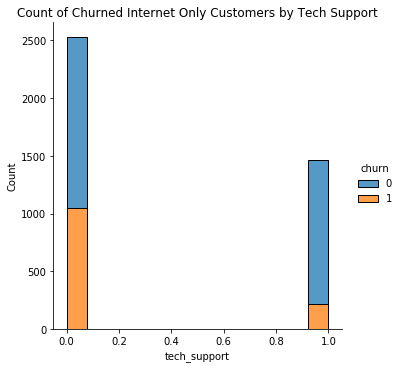

In [51]:
# visual for count of internet customers that have churned or not by tech support
sns.displot(train_internet, x="tech_support",hue="churn", multiple='stack')
plt.title('Count of Churned Internet Only Customers by Tech Support')

### Takeaways
- The chi-squared statistic is a single number that tells you how much difference exists between your observed counts and the counts you would expect if there were no relationship at all in the population
- This number is higher when controlling for internet service only customers
- This shows the difference between churn or not is higher when all customers have the option
    - Churn rate for all customers when not having tech support = .31
    - Churn rate for internet custoemrs when not having tech support = .41

## Automatic Payment
- Does having automatic payments cause lower or higher churn?
- The heat map suggested a correlation between churn and auto_payments, let's test with chi-square again
    - Null hypothesis: Having automatic payments is independent from a customer leaving
    - Null hypothesis: Having automatic payments is independent from a customer leaving

In [12]:
# creating a cross tab of customers with/without automatic payment and is/is not churned
observed3 = pd.crosstab(train.auto_payment, train.churn)

# setting alpha value
a = .01

# scipy function calculates values based on the crosstab created
chi2, p, degf, expected = chi2_contingency(observed3)

print('Observed\n')
print(observed3.values)
print('---\nExpected\n')
print(expected)
print('---\n')
print(f'chi^2 = {chi2:.4f}')
print(f'p     = {p:.4f}')

if p < a:
    print('\nP is less than alpha. We reject the null hypothesis.')

Observed

[[1853 1003]
 [1867  347]]
---
Expected

[[2095.52662722  760.47337278]
 [1624.47337278  589.52662722]]
---

chi^2 = 240.4018
p     = 0.0000

P is less than alpha. We reject the null hypothesis.


Text(0.5, 1, 'Churn Count for Customers With and Without Automatic Payments')

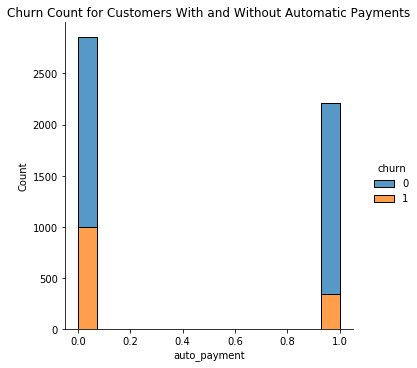

In [55]:
# plotting the distribution of churn by automatic payment
sns.displot(train, x=train.auto_payment, hue=train.churn, multiple='stack')
plt.title('Churn Count for Customers With and Without Automatic Payments')

## Service Type

In [13]:
# to compare service types, need to create a feature for services
# 1 == phone, 2 == internet, 3 == phone and internet
# train happens not to have customers with Fiber Optic but will still acount for them if different random state used

# commenting out, adding to prepare.py file
#train['service_type'] = train.internet_service_type.replace({2:1}) + train.phone_service.replace({2:1})
#train['service_type'].value_counts()

### Two-Sample, T-Test
- Is one service type more likely to churn?
    - Null hypothesis: both services have equivalent churn
    - Alternative hypothesis: either internet or service type have a higher rate of churn

In [14]:
# For comparing churn in service type (internet or phone), will use a two-sample 2-tail t-test
# first sample will be customers with internet only service
x1 = train[train.service_type == 1].churn

# second sample will be cusomters with phone service only
x2 = train[train.service_type == 2].churn

stat, p = ttest_ind(x1, x2)

print(f'statistic = {stat:.3f}')
print(f'p_value = {p:.3f}')

if p < a:
    print('\nP is less than alpha. We reject the null hypothesis.')

statistic = -15.056
p_value = 0.000

P is less than alpha. We reject the null hypothesis.


Text(0.5, 1, 'Churn Count for Phone vs Internet Service')

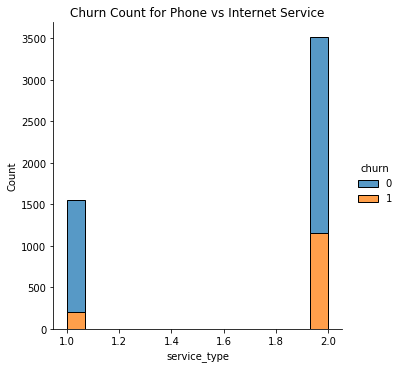

In [53]:
sns.displot(train, x='service_type',hue='churn',multiple='stack')
plt.title('Churn Count for Phone vs Internet Service')

# Modeling
- Split train, validate, split into X variables and y (target) variable
- create the baseline model for comparison with models created
- create multiple models with varying features
- determine the top 3 models

In [15]:
# our predictor/independent features split into train, test, validate
X_train = train.drop(columns = ['churn'],axis=1)
X_validate = validate.drop(columns = ['churn'],axis=1)
X_test = test.drop(columns = ['churn'],axis=1)

# our target variables split into train, test, validate
y_train = train.churn
y_validate = validate.churn
y_test = test.churn

In [16]:
# most of our customers are still with the company (0 = has not churned)
y_train.value_counts()

0    3720
1    1350
Name: churn, dtype: int64

In [17]:
# Most customers do not churn, this will be our baseline prediction
# Creating data frame from actual churn
baseline = pd.DataFrame(y_train)

# Adding baseline as prediction, not churned for every observation
baseline['baseline'] = 0

# Renaming the columns
baseline.columns = ['actual','baseline']

# checking the df
baseline.head()

,actual,baseline
855,1,0
2823,1,0
5656,0,0
1016,0,0
1175,0,0


In [18]:
# To calculate accuracy, create a cross tab of our baseline versus actual
pd.crosstab(baseline['baseline'], baseline['actual'])

actual,0,1
baseline,,
0,3720,1350


In [19]:
# let's calculate the accuracy
# positive will be not churned
# (TP + TN) / (TP + TN + FP + FN)

#predicting not churned and the customer has not churned
TP = 3720

#predicting not churned and the customer has churned
FP = 1350

#predicting the customer has churned and they have churned
TN = 0

#predicting the customer has churned and they have not churned
FN = 0

base_acc = (TP + TN) / (TP + TN + FP + FN)

print("The baseline model is",round(base_acc * 100, 2),"percent.")

The baseline model is 73.37 percent.


## Models
- Using tech_support, automatic payments, service type, contract type, monthly_charges
    - when contract type not included, the model performs the same as the baseline, only predicting not churned
    - when monthly_charges not included, the models all perform the same at %76 percent
    - tweaking the parameters only decreased performance to baseline
- Will use each model type on train, choose three from these to validate

### Logistic Regression - Model 1

In [20]:
X_train1 = X_train[['tech_support','auto_payment','service_type','contract_type','monthly_charges']]
y_train1 = train.churn

In [21]:
# create the model object
logit1 = LogisticRegression(C=100)

# fit to train (only fit it train!)
logit1.fit(X_train1, y_train1)

# displays the correlation of each feature
print('Coefficient: \n', logit1.coef_)
print('\nIntercept: \n', logit1.intercept_)

# predicts churn or not for each customer (1 value)
y_pred1 = logit1.predict(X_train1)

# probability of churn and probability of not churn for each customer (2 values)
y_pred_proba1 = logit1.predict_proba(X_train1)

# accuracy of the model
print('\nAccuracy of Logistic Regression classifier on training set:',logit1.score(X_train1, y_train1))

print('\nThe confusion matrix:\n',confusion_matrix(y_train1, y_pred1))
print('\nClassification report:\n',classification_report(y_train1, y_pred1))

Coefficient: 
 [[-0.64688186 -0.59476696 -0.11208418 -1.5141469   0.02245113]]

Intercept: 
 [-1.34557543]

Accuracy of Logistic Regression classifier on training set: 0.7696252465483234

The confusion matrix:
 [[3302  418]
 [ 750  600]]

Classification report:
               precision    recall  f1-score   support

           0       0.81      0.89      0.85      3720
           1       0.59      0.44      0.51      1350

    accuracy                           0.77      5070
   macro avg       0.70      0.67      0.68      5070
weighted avg       0.75      0.77      0.76      5070



### Takeaways
- Accuracy decreases with C = .01

### Decision Tree - Model 2

In [22]:
X_train2 = X_train[['tech_support','auto_payment','service_type','contract_type','monthly_charges']]
y_train2 = train.churn

In [23]:
clf2 = DecisionTreeClassifier(max_depth = 3)

clf2.fit(X_train2, y_train2)

y_pred2 = clf2.predict(X_train2)
y_pred_proba2 = clf2.predict_proba(X_train2)

#evaluate metrics
print('Accuracy of Decision Tree classifier on training set:', clf2.score(X_train2, y_train2))
print('\nThe confusion matrix:\n',confusion_matrix(y_train2, y_pred2))
print('\nClassification report:\n',classification_report(y_train2, y_pred2))

Accuracy of Decision Tree classifier on training set: 0.7686390532544378

The confusion matrix:
 [[3142  578]
 [ 595  755]]

Classification report:
               precision    recall  f1-score   support

           0       0.84      0.84      0.84      3720
           1       0.57      0.56      0.56      1350

    accuracy                           0.77      5070
   macro avg       0.70      0.70      0.70      5070
weighted avg       0.77      0.77      0.77      5070



### Takeaways
- Max_depth = 3 sets accuracy equal to baseline
- Max_depth 4 and 5 are equal, will use 4

### Random Forest - Model 3

In [24]:
X_train3 = X_train[['tech_support','auto_payment','service_type','contract_type','monthly_charges']]
y_train3 = train.churn

In [25]:
rf3 = RandomForestClassifier(max_depth = 5)

rf3.fit(X_train3, y_train3)

y_pred3 = rf3.predict(X_train3)

y_pred_proba3 = rf3.predict_proba(X_train3)

#print(rf3.feature_importances_)

print('Accuracy of Random Forest classifier on training set:',rf3.score(X_train3, y_train3))
print('\nThe confusion matrix:\n',confusion_matrix(y_train3, y_pred3))
print('\nClassification report:\n',classification_report(y_train3, y_pred3))

Accuracy of Random Forest classifier on training set: 0.7759368836291913

The confusion matrix:
 [[3353  367]
 [ 769  581]]

Classification report:
               precision    recall  f1-score   support

           0       0.81      0.90      0.86      3720
           1       0.61      0.43      0.51      1350

    accuracy                           0.78      5070
   macro avg       0.71      0.67      0.68      5070
weighted avg       0.76      0.78      0.76      5070



### KNN - Model 4

In [26]:
X_train4 = X_train[['tech_support','auto_payment','service_type','contract_type','monthly_charges']]
y_train4 = train.churn

In [27]:
knn4 = KNeighborsClassifier(n_neighbors=10)

knn4.fit(X_train4, y_train4)

y_pred4 = knn4.predict(X_train4)

y_pred_proba4 = knn4.predict_proba(X_train4)

print('Accuracy of KNN classifier on training set:',knn4.score(X_train4, y_train4))
print('\nThe confusion matrix:\n',confusion_matrix(y_train4, y_pred4))
print('\nClassification report:\n',classification_report(y_train4, y_pred4))

Accuracy of KNN classifier on training set: 0.7930966469428008

The confusion matrix:
 [[3445  275]
 [ 774  576]]

Classification report:
               precision    recall  f1-score   support

           0       0.82      0.93      0.87      3720
           1       0.68      0.43      0.52      1350

    accuracy                           0.79      5070
   macro avg       0.75      0.68      0.70      5070
weighted avg       0.78      0.79      0.78      5070



### Validate
- Model 1, Logistic Regression
- Model 3, Random Forest
- Model 4, KNN

In [28]:
X_validate = X_validate[['tech_support','auto_payment','service_type','contract_type','monthly_charges']]
y_validate = validate.churn

In [29]:
print('\nAccuracy of Logistic Regression classifier on validate set:',logit1.score(X_validate, y_validate))

y_pred1 = logit1.predict(X_validate)

print(confusion_matrix(y_validate, y_pred1))

print(classification_report(y_validate, y_pred1))


Accuracy of Logistic Regression classifier on validate set: 0.7943262411347518
[[470  48]
 [ 97  90]]
              precision    recall  f1-score   support

           0       0.83      0.91      0.87       518
           1       0.65      0.48      0.55       187

    accuracy                           0.79       705
   macro avg       0.74      0.69      0.71       705
weighted avg       0.78      0.79      0.78       705



In [30]:
print('\nAccuracy of Random Forest classifier on validate set:',rf3.score(X_validate, y_validate))

y_pred3 = rf3.predict(X_validate)

print(confusion_matrix(y_validate, y_pred3))
print(classification_report(y_validate, y_pred3))


Accuracy of Random Forest classifier on validate set: 0.7957446808510639
[[475  43]
 [101  86]]
              precision    recall  f1-score   support

           0       0.82      0.92      0.87       518
           1       0.67      0.46      0.54       187

    accuracy                           0.80       705
   macro avg       0.75      0.69      0.71       705
weighted avg       0.78      0.80      0.78       705



In [31]:
print('\nAccuracy of KNN classifier on validate set:',knn4.score(X_validate, y_validate))

y_pred4 = knn4.predict(X_validate)

print(confusion_matrix(y_validate, y_pred4))
print(classification_report(y_validate, y_pred4))


Accuracy of KNN classifier on validate set: 0.7829787234042553
[[476  42]
 [111  76]]
              precision    recall  f1-score   support

           0       0.81      0.92      0.86       518
           1       0.64      0.41      0.50       187

    accuracy                           0.78       705
   macro avg       0.73      0.66      0.68       705
weighted avg       0.77      0.78      0.77       705



In [32]:
print(confusion_matrix(y_validate, y_pred4))
tn, fp, fn, tp = confusion_matrix(y_validate, y_pred4).ravel()
print('tn:',tn,'fp:',fp,'fn:',fn,'tp:', tp)

[[476  42]
 [111  76]]
tn: 476 fp: 42 fn: 111 tp: 76


### Takeaways
We consider positive as churn = 1
We consider negative as churn = 0
It costs more to lose customers, so we want the model to predict customers leaving best (positive)
This means we want the best recall/sensitivity
- Model 1, Logistic Regression
    - accuracy is a fraction less than RF
    - false positives and false negatives more evenly split than RF
- Model 3, Random Forest
    - highest accuracy
    - more likely to predict not churned
    - false positives more than false negatives
        - predicts a customer more likely to stay when really they churn
- Model 4, KNN
    - lowest accuracy
### Chosing Model 3, Random Forest for best combination of accuracy and recall

### Test
- Testing on best model from validate

In [33]:
X_test = X_test[['tech_support','auto_payment','service_type','contract_type','monthly_charges']]
y_test = test.churn

In [34]:
print('\nAccuracy of Random Forest classifier on test set:',rf3.score(X_test, y_test))

y_pred3 = rf3.predict(X_test)

print(confusion_matrix(y_test, y_pred3))
print(classification_report(y_test, y_pred3))


Accuracy of Random Forest classifier on test set: 0.7681388012618297
[[839  97]
 [197 135]]
              precision    recall  f1-score   support

           0       0.81      0.90      0.85       936
           1       0.58      0.41      0.48       332

    accuracy                           0.77      1268
   macro avg       0.70      0.65      0.66      1268
weighted avg       0.75      0.77      0.75      1268



# Creating a CSV Deliverable
- apply predictive model to the whole df
- convert to csv file

In [35]:
X = df[['tech_support','auto_payment','service_type','contract_type','monthly_charges']]

# Caveat: X needs to have the same columns as the X_train that was used to fit the model

# model.predict(X) gives us predictions for the entire dataframe
df['prediction'] = rf3.predict(X)
df.head(1)

,customer_id,senior_citizen,tenure_months,phone_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,...,total_charges,churn,contract_type,auto_payment,internet_service_type,Male,part_depd,service_type,tenure_years,prediction
0,0003-MKNFE,0,9,2,0,0,0,0,0,1,...,542.4,0,0,0,1,1,0,2,0.75,0


In [39]:
df_prob = pd.DataFrame(rf3.predict_proba(X))
df_prob = df_prob.drop(0,axis=1)
df_prob.round(3)

,1
0,0.305
1,0.219
2,0.392
3,0.363
4,0.268
...,...
7038,0.011
7039,0.035
7040,0.011
7041,0.017


In [40]:
df = pd.concat([df,df_prob],axis=1)
df = df.rename(columns={1:'prob_of_churn'})

In [41]:
df[['customer_id', 'prob_of_churn','prediction']].to_csv('predictions.csv')

# Conclusions
- Additional features such as tech and support have a slight correlation to reduce churn
- Highest correlation is with contract type
- Suggest:
    - Adding options for support, device protection, etc. for phone service 
    - Can use these as incentives for customers to sign up for yearly contracts